Inspecting directory contents:
Directory: /home/ls/sites/re-blocking/image-generation/brooklyn_comparison/parcels
Total files matching '*': 1000
Sample filenames:
  parcels_000252.jpg
  parcels_000556.jpg
  parcels_000804.jpg
  parcels_000474.jpg
  parcels_000729.jpg


Directory: /home/ls/sites/re-blocking/image-generation/brooklyn_comparison/voronoi
Total files matching '*': 1000
Sample filenames:
  voronoi_000214.jpg
  voronoi_000784.jpg
  voronoi_000240.jpg
  voronoi_000672.jpg
  voronoi_000141.jpg


Directory: /home/ls/sites/re-blocking/ensemble-model/ensemble-output/stable-diffusion
Total files matching '*': 999
Sample filenames:
  ensemble_stable-diffusion_000936.jpg
  ensemble_stable-diffusion_000230.jpg
  ensemble_stable-diffusion_000149.jpg
  ensemble_stable-diffusion_000462.jpg
  ensemble_stable-diffusion_000105.jpg


Directory: /home/ls/sites/re-blocking/data/results/combined-p2p-500-150-v100/test_latest/images
Total files matching '*': 2997
Sample filenames:
  combined_0009

Evaluating voronoi: 100%|██████████| 1000/1000 [00:55<00:00, 18.16it/s]



Processing ensemble...


Evaluating ensemble: 100%|██████████| 999/999 [01:15<00:00, 13.18it/s]



Processing monolithic...


Evaluating monolithic: 100%|██████████| 999/999 [01:16<00:00, 13.07it/s]



Benchmark results saved to: parcel_benchmark_results/comparison_20250319_171047

Summary of model performance:

voronoi:
  ssim: 0.8056
  mse: 23.6525
  psnr: 34.5430
  mean_iou: 0.8353
  laplacian_variance_real: 691.6047
  laplacian_variance_fake: 669.6976
  edge_smoothness: 680.6512
  parcel_area_ratio_real: 0.4953
  parcel_area_ratio_fake: 0.4999
  parcel_area_ratio_diff: 0.0171

ensemble:
  ssim: 0.3421
  mse: 103.4121
  psnr: 27.9899
  mean_iou: 0.3780
  laplacian_variance_real: 691.7107
  laplacian_variance_fake: 98.0793
  edge_smoothness: 394.8950
  parcel_area_ratio_real: 0.4952
  parcel_area_ratio_fake: 0.4868
  parcel_area_ratio_diff: 0.0661

monolithic:
  ssim: 0.3294
  mse: 101.2811
  psnr: 28.0941
  mean_iou: 0.3853
  laplacian_variance_real: 691.7107
  laplacian_variance_fake: 438.3412
  edge_smoothness: 565.0260
  parcel_area_ratio_real: 0.4952
  parcel_area_ratio_fake: 0.4772
  parcel_area_ratio_diff: 0.0638


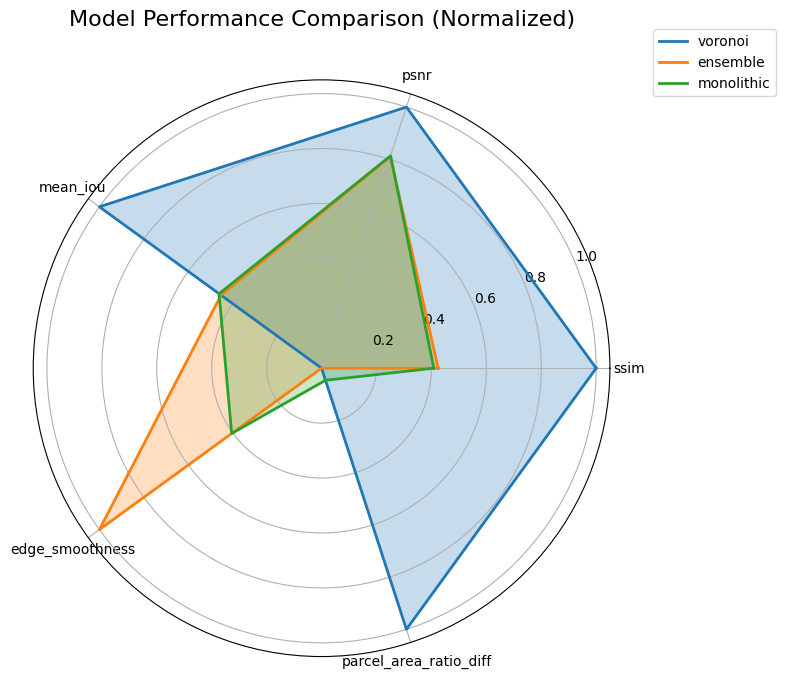

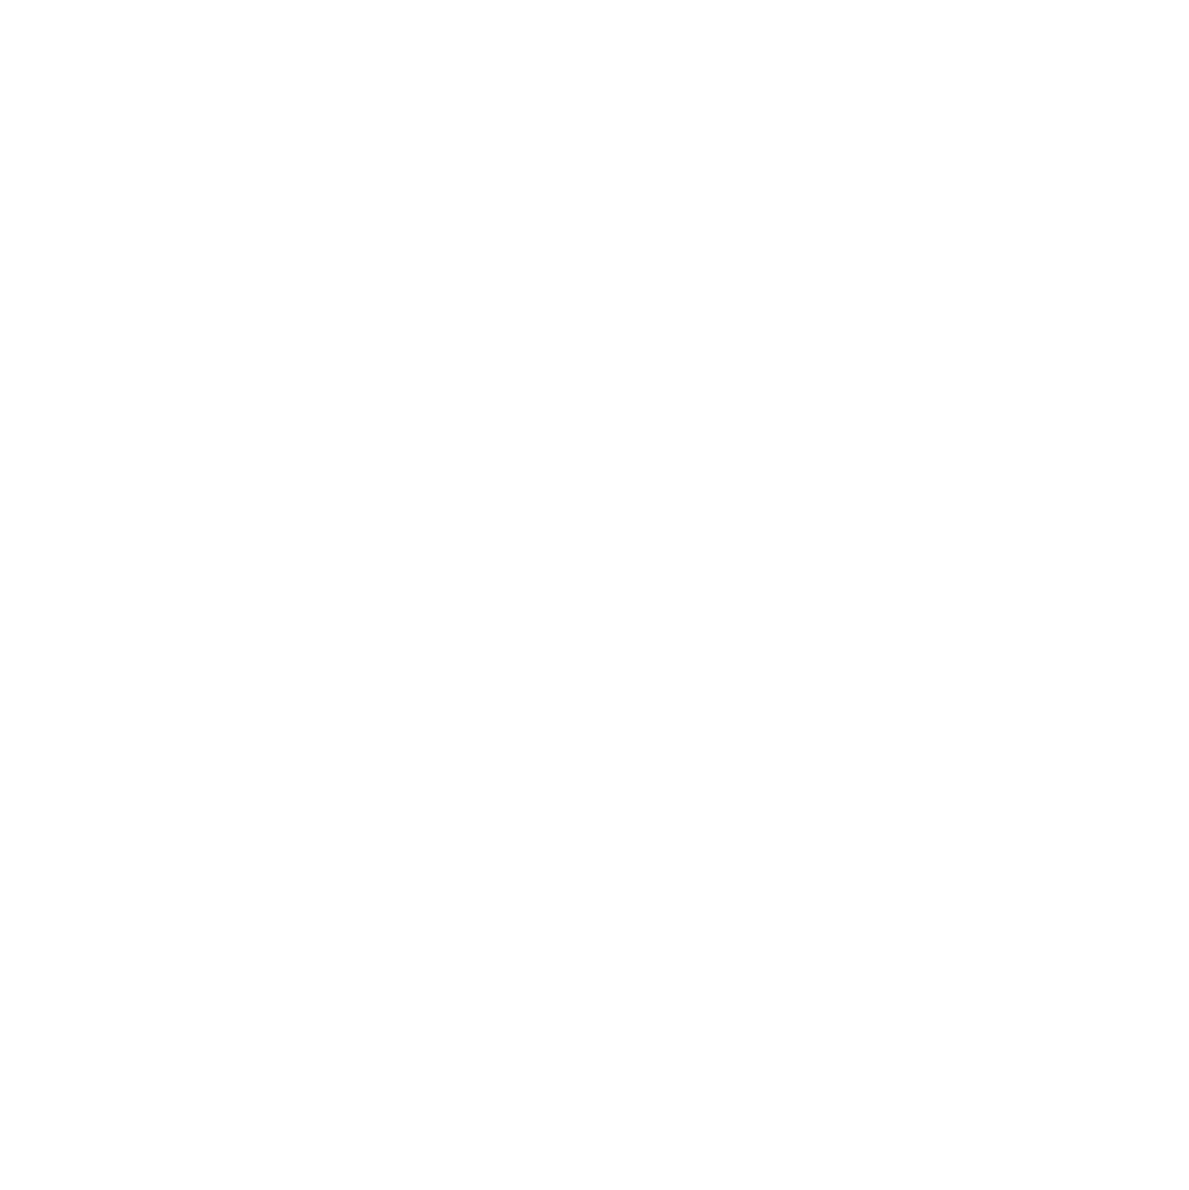

In [3]:
# ---------------------------
# CONFIGURATION & PARAMETERS
# ---------------------------
COMPARISON_CONFIG = {
    "DEFAULT_OUTPUT_DIR": "comparison_results",
    "PLOTS_SUBDIRECTORY": "plots",
    "REPORTS_SUBDIRECTORY": "reports",
    "KEY_METRICS": {
        "ssim": "SSIM",
        "mse": "MSE",
        "psnr": "PSNR (dB)",
        "mean_iou": "Mean IoU",
        "edge_smoothness": "Edge Smoothness",
        "parcel_area_ratio_diff": "Parcel Area Ratio Diff"
    },
    "BAR_PLOT_SIZE": (8, 6),
    "PLOT_GRID_STYLE": "--",
    "PLOT_GRID_ALPHA": 0.7,
    "DECIMAL_PLACES": 4,
    "MODEL_COLORS": {"voronoi": "blue", "ensemble": "green", "monolithic": "red"}
}

DIR_EVAL_CONFIG = {
    "DEFAULT_BENCHMARK_DIR": "benchmarks",
    "BATCH_SIZE": 100,
    "PARALLEL_PROCESSING": False,
    "NUM_WORKERS": 4,
    "SAVE_DETAILED_METRICS": True,
    "SAVE_SUMMARY_STATS": True,
    "REPORT_DECIMAL_PLACES": 4,
    "INCLUDE_TIMESTAMPS": True
}

PARCEL_CONFIG = {
    "MIN_AREA": 100,
    "COLOR_DIST_THRESHOLD": 50,
    "WIN_SIZE_FOR_SSIM": 7,
    "SAVE_VISUALIZATIONS": True,
    "CHUNK_SIZE": 10,
    "CONTOUR_EPSILON_FACTOR": 0.01
}

# Folder paths to process – change these as needed:
MODEL_PATHS = {
    'parcels': "/home/ls/sites/re-blocking/image-generation/brooklyn_comparison/parcels",
    'voronoi': "/home/ls/sites/re-blocking/image-generation/brooklyn_comparison/voronoi",
    'ensemble': "/home/ls/sites/re-blocking/ensemble-model/ensemble-output/stable-diffusion",
    'monolithic': "/home/ls/sites/re-blocking/data/results/combined-p2p-500-150-v100/test_latest/images"
}

OUTPUT_DIR = "parcel_benchmark_results"

# ---------------------------
# IMPORTS & HELPER FUNCTIONS
# ---------------------------
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from datetime import datetime
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
from skimage.metrics import structural_similarity as ssim
import math

def find_matching_files(real_dir, fake_dir, real_suffix='.jpg', fake_suffix='.jpg'):
    """
    Find matching files from two directories.
    Dummy implementation: sorts files by name and pairs them.
    Adjust if your folder structure or naming is more complex.
    """
    real_files = sorted(Path(real_dir).glob(f"*{real_suffix}"))
    fake_files = sorted(Path(fake_dir).glob(f"*{fake_suffix}"))
    matched = []
    for r, f in zip(real_files, fake_files):
        matched.append((r, f))
    return matched

def process_image_worker(args):
    evaluator, real_file, fake_file, vis_dir = args
    try:
        metrics, _ = evaluator.evaluate(real_file, fake_file, vis_dir)
        return metrics
    except Exception as e:
        print(f"Error processing {fake_file.name}: {str(e)}")
        return None

def compute_mse(img1, img2):
    """Compute mean squared error between two images."""
    return np.mean((img1 - img2) ** 2)

def compute_psnr(img1, img2):
    """Compute PSNR given two images (assumes 8-bit images)."""
    mse_val = compute_mse(img1, img2)
    if mse_val == 0:
        return float('inf')
    max_i = 255.0
    return 20 * math.log10(max_i) - 10 * math.log10(mse_val)

def compute_laplacian_variance(image):
    """Compute the variance of the Laplacian (measure of edge sharpness)."""
    lap = cv2.Laplacian(image, cv2.CV_64F)
    return lap.var()

def overlay_parcels(image, mask, color=(0, 255, 0), alpha=0.5):
    """
    Overlay a colored mask on the image.
    image: original BGR image (np.array)
    mask: binary mask (255=parcel, 0=background)
    """
    overlay = image.copy()
    overlay[mask == 255] = color
    combined = cv2.addWeighted(image, 1 - alpha, overlay, alpha, 0)
    return combined

def compute_parcel_area_ratio(mask):
    """
    Compute the ratio of pixels belonging to parcels.
    mask: binary mask with 255 for parcel, 0 for background.
    """
    return np.sum(mask == 255) / mask.size

# ---------------------------
# COMPARISON PLOTTING & SUMMARY FUNCTIONS
# ---------------------------
def create_comparison_plots(model_results, output_dir):
    decimal_places = COMPARISON_CONFIG.get("DECIMAL_PLACES", 4)
    model_colors = COMPARISON_CONFIG.get("MODEL_COLORS", {})
    for metric, metric_label in COMPARISON_CONFIG['KEY_METRICS'].items():
        plt.figure(figsize=COMPARISON_CONFIG['BAR_PLOT_SIZE'])
        values = [results['avg_metrics'][metric] for results in model_results.values()]
        models = list(model_results.keys())
        bars = plt.bar(models, values, color=[model_colors.get(model, None) for model in models])
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.{decimal_places}f}',
                     ha='center', va='bottom')
        plt.grid(True, axis='y', linestyle=COMPARISON_CONFIG['PLOT_GRID_STYLE'],
                 alpha=COMPARISON_CONFIG['PLOT_GRID_ALPHA'])
        plt.tight_layout()
        plt.savefig(output_dir / f"{metric_label}_bar_plot.png")
        plt.close()

def save_comparative_summary(model_results, parent_dir):
    summary = {}
    for model_name, data in model_results.items():
        summary[model_name] = data['avg_metrics'].to_dict()
    summary_path = parent_dir / "comparative_summary.json"
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=4)

def inspect_directory_contents(directory):
    p = Path(directory)
    files = list(p.glob("*"))
    print(f"Directory: {directory}")
    print(f"Total files matching '*': {len(files)}")
    sample_files = [f.name for f in files[:5]]
    print("Sample filenames:")
    for name in sample_files:
        print(f"  {name}")
    print("\n")

# ---------------------------
# RADAR CHART FUNCTION FOR SUMMARY VISUALIZATION
# ---------------------------
def plot_radar_chart(model_results):
    import matplotlib.pyplot as plt
    import numpy as np

    # Metrics for radar chart (normalized)
    metrics = ["ssim", "psnr", "mean_iou", "edge_smoothness", "parcel_area_ratio_diff"]
    models = list(model_results.keys())
    data = []
    for model in models:
        values = []
        for metric in metrics:
            values.append(model_results[model]['avg_metrics'][metric])
        data.append(values)
    data = np.array(data)  # shape: (num_models, num_metrics)
    
    # Normalize data per metric across models.
    norm_data = np.zeros_like(data)
    for j, metric in enumerate(metrics):
        column = data[:, j]
        if metric in ["ssim", "psnr", "mean_iou"]:
            max_val = np.max(column)
            norm_data[:, j] = column / max_val if max_val != 0 else column
        else:
            min_val = np.min(column)
            max_val = np.max(column)
            if max_val > min_val:
                norm_data[:, j] = 1 - ((column - min_val) / (max_val - min_val))
            else:
                norm_data[:, j] = column

    num_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for i, model in enumerate(models):
        values = norm_data[i].tolist()
        values += values[:1]
        ax.plot(angles, values, label=model, linewidth=2)
        ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_title("Model Performance Comparison (Normalized)", size=16, y=1.08)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.savefig("comparison_radar_chart.png", dpi=300)
    plt.show()

# ---------------------------
# SAMPLE COMPARISON VISUALIZATION FUNCTION
# ---------------------------
def plot_sample_comparisons(sample_indices, benchmark_dir, model_names):
    """
    For a list of sample indices, load overlay images from each model's visualization folder and display them side by side.
    
    Parameters:
      sample_indices: List of integer indices (e.g., [0, 1, 2])
      benchmark_dir: The root benchmark directory (output directory used in the evaluation)
      model_names: List of model names to include (e.g., ["voronoi", "ensemble", "monolithic"])
    """
    import matplotlib.pyplot as plt
    from pathlib import Path
    fig, axes = plt.subplots(len(model_names), len(sample_indices), figsize=(4 * len(sample_indices), 4 * len(model_names)))
    
    # Ensure axes is a 2D array
    if len(model_names) == 1:
        axes = np.expand_dims(axes, axis=0)
    if len(sample_indices) == 1:
        axes = np.expand_dims(axes, axis=1)
    
    for i, model in enumerate(model_names):
        vis_dir = Path(benchmark_dir) / model / "visualizations"
        overlay_files = sorted(list(vis_dir.glob("*_overlay_fake.jpg")))
        for j, idx in enumerate(sample_indices):
            ax = axes[i][j]
            if idx < len(overlay_files):
                img = plt.imread(str(overlay_files[idx]))
                ax.imshow(img)
                ax.set_title(f"{model} Sample {idx}")
                ax.axis('off')
            else:
                ax.axis('off')
    plt.tight_layout()
    plt.savefig("sample_comparison.png", dpi=300)
    plt.show()

# ---------------------------
# MODEL EVALUATION PIPELINE FUNCTIONS
# ---------------------------
def evaluate_multiple_models(model_paths=None, benchmark_dir=COMPARISON_CONFIG['DEFAULT_OUTPUT_DIR'], ground_truth_dir=None):
    if model_paths is None:
        model_paths = {
            'parcels': "./parcels",  # Ground truth
            'voronoi': "./voronoi",
            'ensemble': "./ensemble",
            'monolithic': "./monolithic"
        }
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    parent_dir = Path(benchmark_dir) / f"comparison_{timestamp}"
    parent_dir.mkdir(parents=True, exist_ok=True)
    
    plots_dir = parent_dir / COMPARISON_CONFIG['PLOTS_SUBDIRECTORY']
    reports_dir = parent_dir / COMPARISON_CONFIG['REPORTS_SUBDIRECTORY']
    plots_dir.mkdir(exist_ok=True)
    reports_dir.mkdir(exist_ok=True)
    
    print("Inspecting directory contents:")
    for name, path in model_paths.items():
        inspect_directory_contents(path)
    if ground_truth_dir and ground_truth_dir not in model_paths.values():
        inspect_directory_contents(ground_truth_dir)
    
    reference_dir = ground_truth_dir
    if reference_dir is None and 'parcels' in model_paths:
        reference_dir = model_paths['parcels']
        model_paths_copy = model_paths.copy()
        del model_paths_copy['parcels']
        model_paths = model_paths_copy
    
    model_results = {}
    for model_name, base_path in model_paths.items():
        print(f"\nProcessing {model_name}...")
        base_path = Path(base_path)
        real_dir = reference_dir if reference_dir is not None else base_path
        
        try:
            if model_name == 'voronoi':
                real_suffix = '.jpg'
                fake_suffix = '.jpg'
            elif model_name == 'monolithic':
                real_suffix = '.jpg'
                fake_suffix = '_fake_B.png'
            else:
                real_suffix = '.jpg'
                fake_suffix = '.jpg'
            
            matched_pairs = find_matching_files(real_dir, base_path, real_suffix, fake_suffix)
            if not matched_pairs:
                raise ValueError(f"No matching files found for {model_name}")
                
            evaluator = ParcelEvaluator()
            benchmark_id = evaluator.create_benchmark_id(model_name)
            output_dir = evaluator.setup_output_directory(parent_dir / model_name, benchmark_id)
            evaluator.save_config(output_dir)
            
            all_results = []
            for real_file, fake_file in tqdm(matched_pairs, desc=f"Evaluating {model_name}"):
                try:
                    metrics, _ = evaluator.evaluate(real_file, fake_file, output_dir / "visualizations")
                    if metrics:
                        metrics['file_name'] = fake_file.name
                        all_results.append(metrics)
                except Exception as e:
                    print(f"Error processing {fake_file.name}: {str(e)}")
            
            if not all_results:
                raise ValueError(f"No successful evaluations for {model_name}")
            
            df = pd.DataFrame(all_results)
            df.to_csv(output_dir / "metrics" / "detailed_metrics.csv", index=False)
            avg_metrics = df.mean(numeric_only=True)
            summary_dict = {
                'model_name': model_name,
                'average_metrics': avg_metrics.to_dict(),
                'total_images_processed': len(all_results),
                'timestamp': datetime.now().isoformat()
            }
            with open(output_dir / "metrics" / "summary.json", 'w') as f:
                json.dump(summary_dict, f, indent=4)
            
            model_results[model_name] = {
                'metrics_df': df,
                'benchmark_id': benchmark_id,
                'avg_metrics': avg_metrics,
            }
        except Exception as e:
            print(f"Error evaluating model {model_name}: {str(e)}")
            continue
    
    if not model_results:
        print("No models were successfully evaluated.")
        return {}, parent_dir
    
    create_comparison_plots(model_results, plots_dir)
    save_comparative_summary(model_results, parent_dir)
    return model_results, parent_dir

def run_custom_benchmark():
    results, benchmark_dir = evaluate_multiple_models(model_paths=MODEL_PATHS, benchmark_dir=OUTPUT_DIR)
    print(f"\nBenchmark results saved to: {benchmark_dir}")
    return results, benchmark_dir

# ---------------------------
# EVALUATION CLASS WITH UPDATED RESIZING
# ---------------------------
class ParcelEvaluator:
    def __init__(self,
                 min_area=PARCEL_CONFIG['MIN_AREA'],
                 color_dist_threshold=PARCEL_CONFIG['COLOR_DIST_THRESHOLD'],
                 win_size_for_ssim=PARCEL_CONFIG['WIN_SIZE_FOR_SSIM'],
                 save_visualizations=PARCEL_CONFIG['SAVE_VISUALIZATIONS']):
        self.min_area = min_area
        self.color_dist_threshold = color_dist_threshold
        self.win_size_for_ssim = win_size_for_ssim
        self.save_visualizations = save_visualizations
        self.chunk_size = PARCEL_CONFIG['CHUNK_SIZE']
        self.contour_epsilon_factor = PARCEL_CONFIG['CONTOUR_EPSILON_FACTOR']

    def create_benchmark_id(self, model_name=None):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        if model_name:
            return f"{model_name}_{timestamp}"
        return f"benchmark_{timestamp}"

    def setup_output_directory(self, base_dir, benchmark_id):
        output_dir = Path(base_dir) / benchmark_id
        (output_dir / "visualizations").mkdir(parents=True, exist_ok=True)
        (output_dir / "metrics").mkdir(parents=True, exist_ok=True)
        return output_dir

    def save_config(self, output_dir):
        config = {
            'min_area': self.min_area,
            'color_dist_threshold': self.color_dist_threshold,
            'win_size_for_ssim': self.win_size_for_ssim,
            'timestamp': datetime.now().isoformat()
        }
        with open(output_dir / "metrics" / "config.json", 'w') as f:
            json.dump(config, f, indent=4)

    def evaluate(self, real_file, fake_file, visualization_dir):
        """
        Evaluate a pair of images and compute metrics:
          - SSIM, MSE, PSNR
          - IoU for binary parcel masks (thresholded at 127)
          - Edge smoothness (via Laplacian variance)
          - Parcel area ratio difference (from binary masks)
          - Save SSIM map and overlay images for visual inspection.
          
        This updated version ensures that if the fake image has different dimensions,
        it is resized to match the real image.
        """
        # Load images
        real_img = cv2.imread(str(real_file))
        fake_img = cv2.imread(str(fake_file))
        if real_img is None or fake_img is None:
            raise ValueError(f"Error loading images: {real_file}, {fake_file}")
        
        # Resize fake image if dimensions differ from real image
        if real_img.shape != fake_img.shape:
            fake_img = cv2.resize(fake_img, (real_img.shape[1], real_img.shape[0]), interpolation=cv2.INTER_AREA)
        
        # Convert to grayscale
        real_gray = cv2.cvtColor(real_img, cv2.COLOR_BGR2GRAY)
        fake_gray = cv2.cvtColor(fake_img, cv2.COLOR_BGR2GRAY)
        
        # Compute SSIM and full SSIM map
        ssim_val, ssim_map = ssim(real_gray, fake_gray, full=True, win_size=self.win_size_for_ssim)
        
        # Compute MSE and PSNR
        mse_val = compute_mse(real_gray, fake_gray)
        psnr_val = compute_psnr(real_gray, fake_gray)
        
        # Threshold images to obtain binary parcel masks
        ret, real_thresh = cv2.threshold(real_gray, 127, 255, cv2.THRESH_BINARY)
        ret, fake_thresh = cv2.threshold(fake_gray, 127, 255, cv2.THRESH_BINARY)
        
        # Compute IoU for the parcel masks
        intersection = np.logical_and(real_thresh == 255, fake_thresh == 255).sum()
        union = np.logical_or(real_thresh == 255, fake_thresh == 255).sum()
        iou_val = intersection / union if union > 0 else 0
        
        # Compute edge smoothness via Laplacian variance
        lap_var_real = compute_laplacian_variance(real_gray)
        lap_var_fake = compute_laplacian_variance(fake_gray)
        edge_smoothness = (lap_var_real + lap_var_fake) / 2.0
        
        # Compute parcel area ratios and their difference
        area_ratio_real = compute_parcel_area_ratio(real_thresh)
        area_ratio_fake = compute_parcel_area_ratio(fake_thresh)
        area_ratio_diff = abs(area_ratio_real - area_ratio_fake)
        
        # Create overlays of colored parcel masks on the original images
        colored_real = overlay_parcels(real_img, real_thresh, color=(0, 255, 0), alpha=0.5)
        colored_fake = overlay_parcels(fake_img, fake_thresh, color=(0, 255, 0), alpha=0.5)
        
        # Optionally, save visualizations (SSIM map and overlays)
        if self.save_visualizations:
            vis_dir = Path(visualization_dir)
            vis_dir.mkdir(parents=True, exist_ok=True)
            ssim_vis_path = vis_dir / f"{fake_file.stem}_ssim.png"
            plt.imsave(str(ssim_vis_path), ssim_map, cmap='gray')
            cv2.imwrite(str(vis_dir / f"{fake_file.stem}_overlay_real.jpg"), colored_real)
            cv2.imwrite(str(vis_dir / f"{fake_file.stem}_overlay_fake.jpg"), colored_fake)
        
        metrics = {
            "ssim": ssim_val,
            "mse": mse_val,
            "psnr": psnr_val,
            "mean_iou": iou_val,
            "laplacian_variance_real": lap_var_real,
            "laplacian_variance_fake": lap_var_fake,
            "edge_smoothness": edge_smoothness,
            "parcel_area_ratio_real": area_ratio_real,
            "parcel_area_ratio_fake": area_ratio_fake,
            "parcel_area_ratio_diff": area_ratio_diff
        }
        return metrics, None

# ---------------------------
# MAIN EXECUTION
# ---------------------------
if __name__ == "__main__":
    # Run the benchmark
    results, benchmark_dir = run_custom_benchmark()
    print("\nSummary of model performance:")
    for model_name, model_data in results.items():
        print(f"\n{model_name}:")
        for metric, value in model_data['avg_metrics'].items():
            if isinstance(value, (int, float)):
                print(f"  {metric}: {value:.{DIR_EVAL_CONFIG['REPORT_DECIMAL_PLACES']}f}")
    
    # Generate radar chart for summary
    plot_radar_chart(results)
    
    # Optionally, pick a few sample indices (e.g., 0, 1, 2) and display visual comparisons
    sample_indices = [0, 1, 2]  # Change these indices as desired
    # The model names we evaluated are the keys in MODEL_PATHS except 'parcels'
    sample_model_names = list(MODEL_PATHS.keys())
    sample_model_names.remove('parcels')
    plot_sample_comparisons(sample_indices, benchmark_dir, sample_model_names)